# Описание проекта

Маркетологи "Метанпромбанк" решили развернуть стратегию удержания клиентов. 

В распоряжении имеетя датасет, который содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Цель исследования - проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

В рамках этого проекта поставленны следующие задачи:

* Провести исследовательский анализ данных, определите все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравните портреты типичных клиентов, которые склонны и не склонныуходить из банка и т.д)
* Сформулировать и проверить статистические гипотезы.
* Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
* Объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие и дать по ним рекомендации

# Шаг 0. Импорт библиотек, выгрузка данных

In [1]:
import pandas as pd
import numpy as np
!pip install phik
import phik
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('здесь была ссылка на датасет')
df_raw = df
display(df.head())

     |████████████████████████████████| 679 kB 2.2 MB/s eta 0:00:01


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


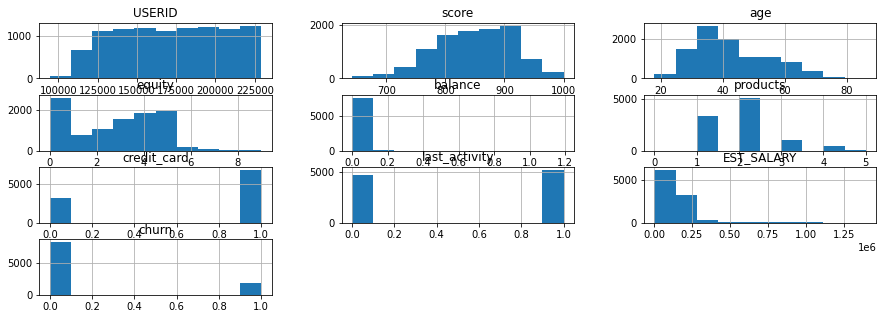

In [3]:
df.hist(figsize=(15,5));

In [4]:
df.gender.unique()

array(['Ж', 'М'], dtype=object)

In [5]:
df.city.unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [6]:
df.duplicated().sum()

0

In [7]:
data_loss = df.isnull().sum().to_frame()
data_loss['ratio'] = (data_loss[0] / len(df))*100
data_loss

,0,ratio
USERID,0,0.00
score,0,0.00
city,0,0.00
gender,0,0.00
age,26,0.26
equity,0,0.00
balance,2295,22.95
products,0,0.00
credit_card,0,0.00
last_activity,0,0.00


В целом, данные выглядят достаточно неплохо, посмотрим, что можно сделать с пропусками.

# Шаг 1. Предобработка данных

In [8]:
#Переименуем колонки
df = df.rename(columns={'USERID': 'user_id', 'EST_SALARY':'est_salary'})

## Обработка дубликатов полных / id пользователей

In [9]:
df.user_id.duplicated().sum()

73

In [10]:
pd.set_option('display.max_rows', None)
df[df.user_id.duplicated(keep=False) == True].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


Более детальное изучение среза фрейма gоказало, что пересечение по user_id скорее результат технической ошибки из-за слияния таблиц, т.к. строки содержат различающиеся данные, пригодные для анализа.

## Обработка пропусков 

Для обработки пропусков в столбцах возраста и баланса счета, нужно изучить их более детально.

In [11]:
df_loss = df[df.age.isnull() == True]
df_loss

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


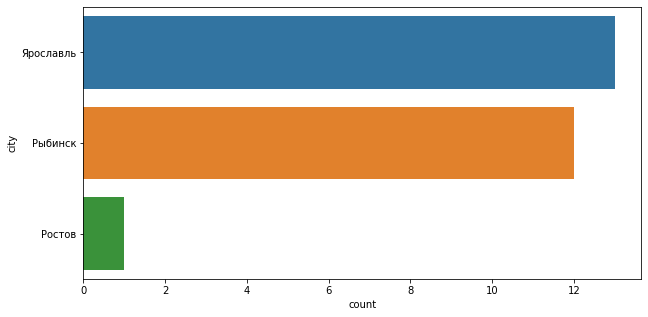

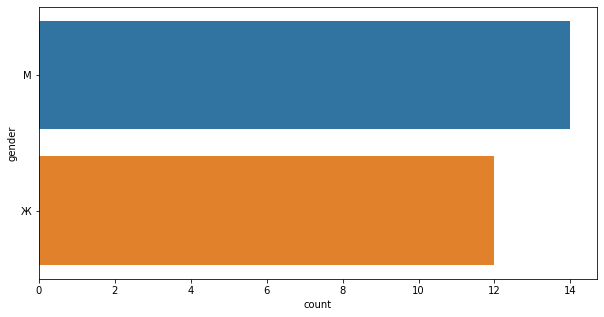

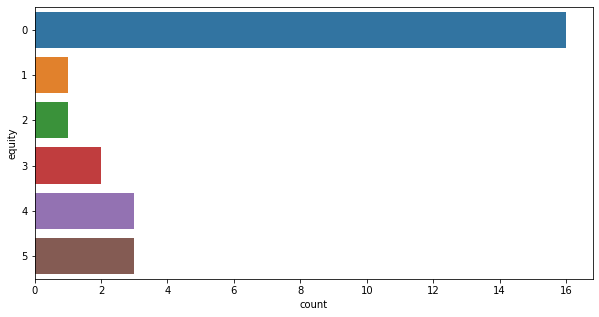

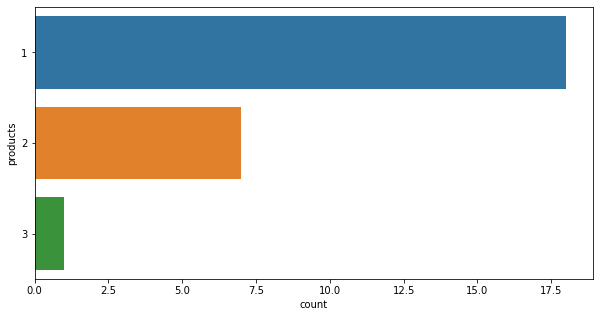

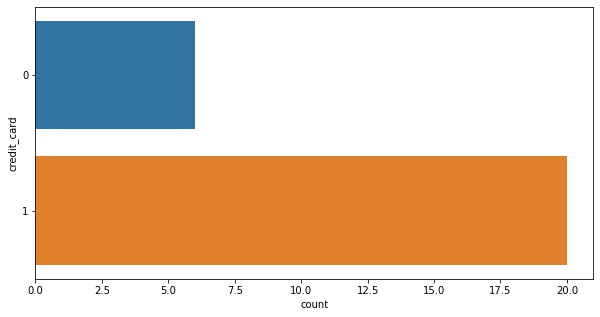

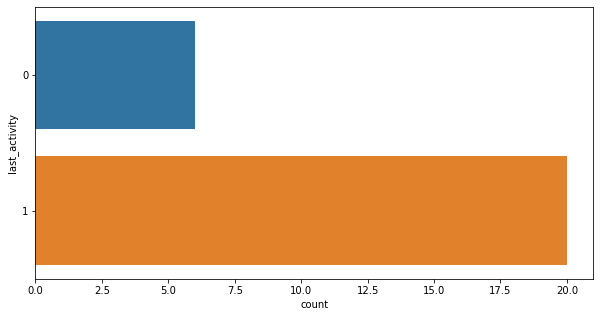

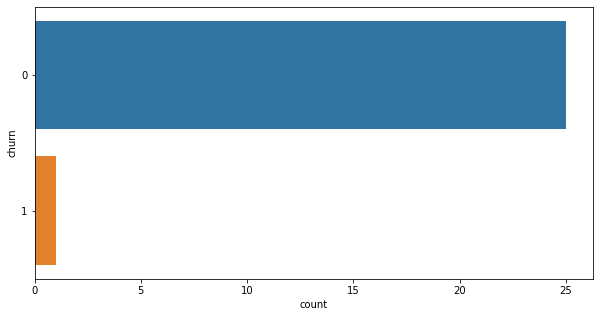

In [12]:
df_list = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']
for i in df_list:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df_loss, y= str(i))

Всего 26 пропущенных значения, возьмем медианное значение по ДС и заполним пропуски, т.к. пропуски в `age` можно отнести к MAR (Missing At Random / Отсутствует случайно). 

In [13]:
df.age = df.age.fillna(value = df.age.median())

Изучим пропуски в балансе счета.

In [14]:
df_loss_balance = df[df.balance.isnull() == True]

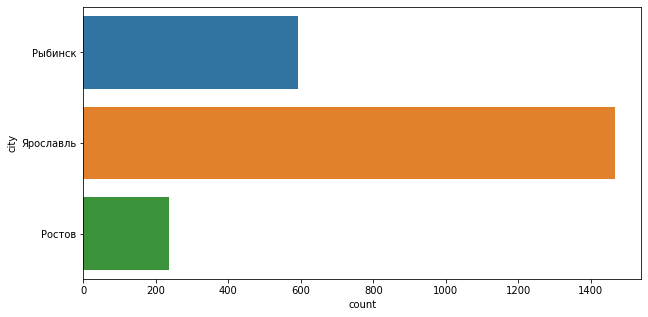

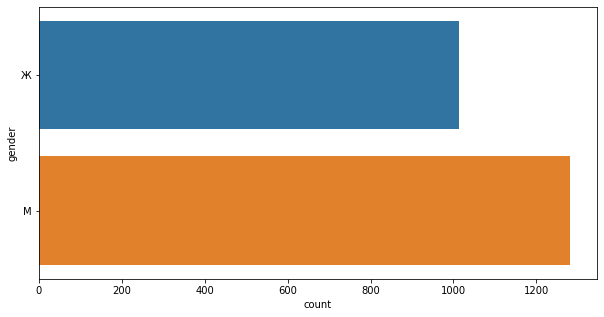

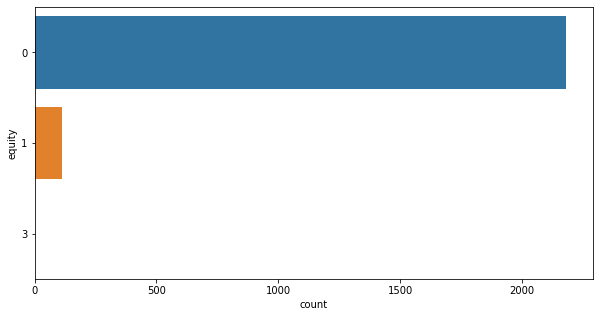

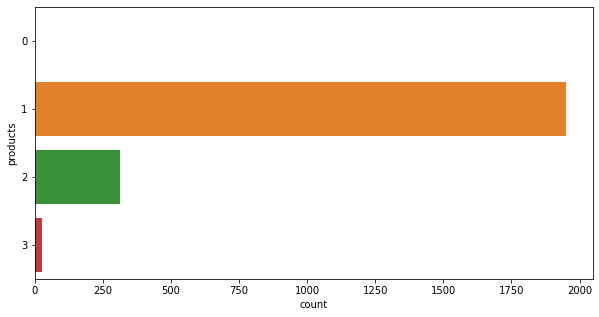

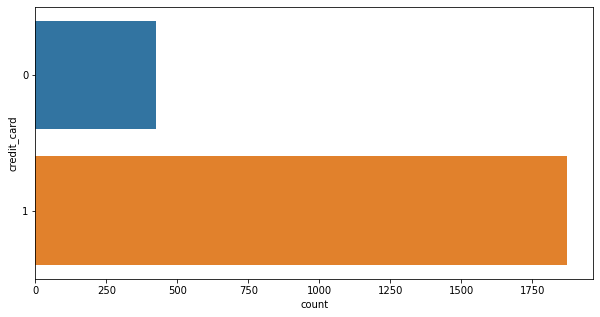

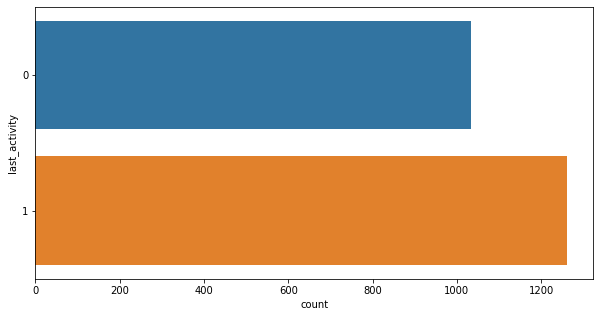

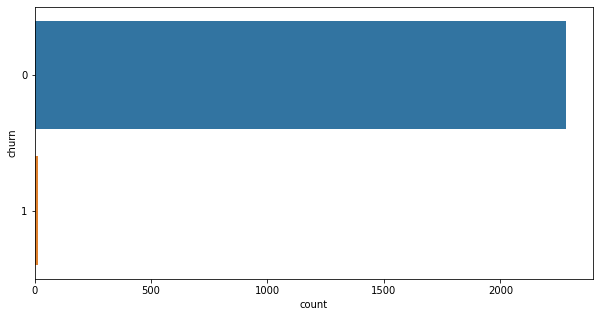

In [15]:
#Техническая проверка того, как распределились данные в строках, где пропущен баланс счета, графики не подписываю
df_list = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']
for i in df_list:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df_loss_balance, y= str(i))

В результате, нельзя связать пропуски с данными в каком либо из столбцов, вероятнее всего технический сбой, отнесем их к типу MNAR (Missing Not At Random / Отсутствует не случайно). В любом случае, заполнять пропуски в данном столбце не корреткно, это исказит результаты дальнейшего исследования, таких пропусков довольно весомое количество.

## Перекодировать city и gender для .corr()

Перекодируем категориальные переменные gender и city.

In [16]:
code_df = pd.get_dummies(df, columns=['gender'], drop_first= True)
code_df = pd.get_dummies(df, columns=['city'])
code_df = code_df.iloc [:,1:]
display(code_df.head())

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
0,850.0,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,861.0,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,892.0,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,866.0,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,730.0,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


In [17]:
# Проверим сколько данных осталось после обработки
len(df)/len(df_raw)*100

100.0

Потеряли менее процента данных, хороший показатель, двигаемся дальше.

# Шаг 2. Исследовательский анализ данных

## Выделить значимые признаки отточности

Первоначально, посчитаем средний отток по банку. Эти данные пригодятся нам позже.

In [18]:
df_churn = df.query('churn == 1')
df_churn_0 = df.query('churn == 0')
churn_rate = len(df_churn)/len(df)*100
print(churn_rate)

18.2


Начнем с корреляционного анализа. Это позволит нам выявить наличие корреляционной связи, если таковая имеется, и в дальнейшем при исследовательском анализе данных обратить внимание именно на эти критерии.

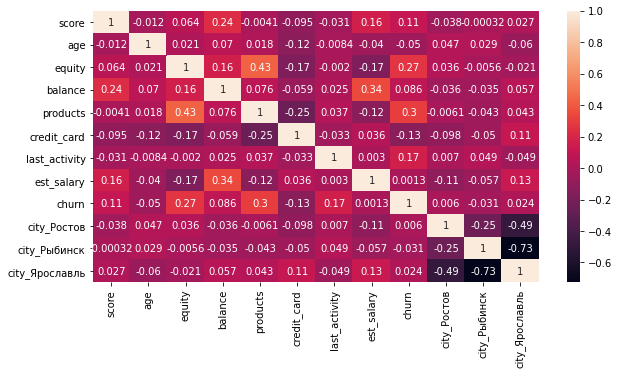

In [19]:
tab_corr = code_df.corr()

plt.figure(figsize=(10,5))
sns.heatmap(tab_corr, annot=True);

In [20]:
phik_matrix = code_df.phik_matrix(interval_cols=['balance', 'est_salary', 'age', 'score'])

In [21]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


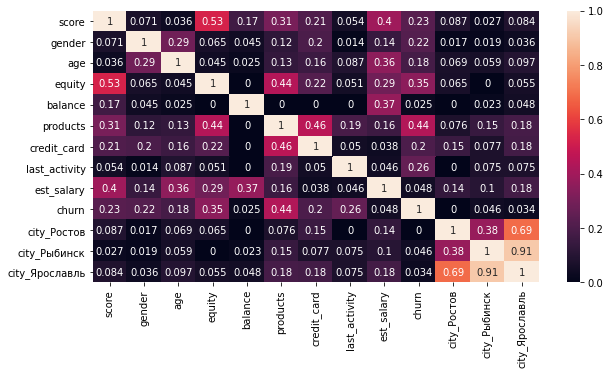

In [22]:
plt.figure(figsize=(10,5))
sns.heatmap(phik_matrix, annot=True);

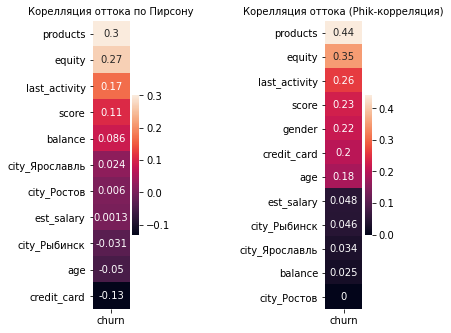

In [23]:
fig, axes = plt.subplots( 1,2, figsize=(5,5))
sns.heatmap(tab_corr[['churn']].sort_values(by='churn', ascending=False).drop(['churn'], axis=0), annot=True, ax=axes[0])
sns.heatmap(phik_matrix[['churn']].sort_values(by='churn', ascending=False).drop(['churn'], axis=0), annot=True, ax=axes[1])
axes[0].set_title('Корелляция оттока по Пирсону', fontsize = '10')
axes[1].set_title('Корелляция оттока (Phik-корреляция)', fontsize = '10')
plt.subplots_adjust(hspace = 1, wspace=4, top=1, bottom=0.2);

Корреляционный анализ может нам продемонстрировать наличие взаимосвязи между параметрами, однако не дает информации, насколько сильной является связь между ними. Проверим факторы которые сильнее всего связанны с оттоком (скорее, более в относительном, чем абсолютном выражении).

**К таким факторам относятся (По Пирсону):**
1) Наличие продуктов, которыми пользуется клиент (Products, коэффициент 0,3, phik 0.44)

2) Количество баллов собственности (Equity, коэффициент 0,27)

3) Статус активного клиента (Last_activity, коэффициент 0,17)

4) Баллы кредитного скоринга, (Score, коэффициент 0,11)

5) Наличие кредитной карты (Credit_сard, коэффициент -0,13)

**Факторы по Phik-корреляции, которые рассмотрим дополнительно:**

1) Пол (0,22)

2) Возраст (0,2)


**Выводы по корреляционному анализу:** 

* В целом, имеющуюся корреляцию можно оценить как слабую и очень слабую, в обеих методиках расчета по параметру оттока мы не получаем коэфициент выше 0,44. 

* Несмотря на расхождения коэфициентов между методиками, можно отметить что в целом, они обращают внимание на одни и те же факторы.

Проанализируем эти данные детальнее.

## Выявить интервалы значений характеристик, которые связаны с повышенным оттоком

Визуализируем данные, для их дальнейшего анализа.

In [24]:
df_rename = df
df_rename = df_rename.rename(columns={'products': 'Количество продуктов', 'score': 'Баллы кредитного скоринга',  'last_activity':'Активный клиент', 
                                      'equity':'Количество баллов собственности', 'balance':'Баланс на счёте', 
                                      'credit_card':'Есть ли кредитная карта?', 'gender':'Пол', 'age':'Возраст', 
                                     'churn':'Показатель оттока', 'city': 'Город', 'est_salary':'Заработная плата клиента'})


corr_labels_nepr = ['Баллы кредитного скоринга', 'Возраст']
corr_labels_discr = ['Активный клиент', 'Есть ли кредитная карта?', 'Пол', 'Город']


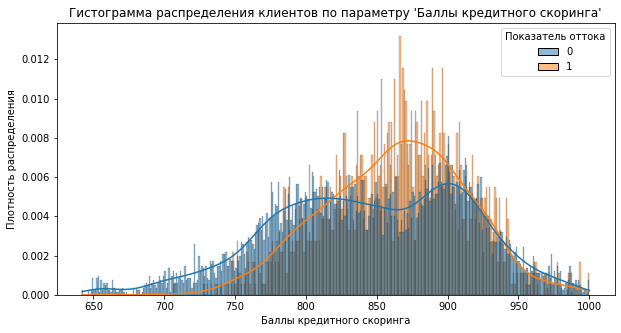

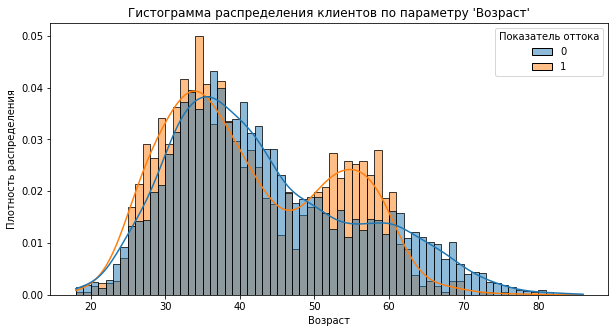

In [25]:
for i in corr_labels_nepr:
    plt.figure(figsize=(10,5))
    plt.title(f"Гистограмма распределения клиентов по параметру '{str(i)}'")
    sns.histplot(data=df_rename, x= str(i), hue='Показатель оттока', stat='density', common_norm=False, kde=True, binwidth=1)
    plt.ylabel('Плотность распределения');

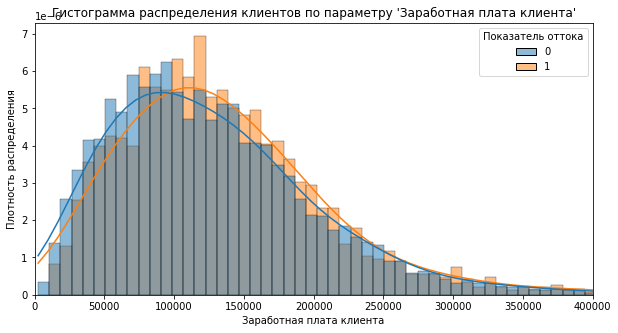

In [26]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Заработная плата клиента'")
sns.histplot(data=df_rename, x= 'Заработная плата клиента', hue='Показатель оттока', stat='density', 
             common_norm=False, kde=True, binwidth=8000)
plt.ylabel('Плотность распределения')
plt.xlim(0, 400000);

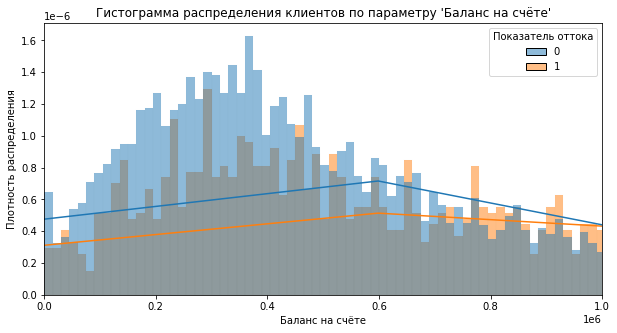

In [27]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Баланс на счёте'")
sns.histplot(data=df_rename, x='Баланс на счёте', hue='Показатель оттока', stat='density', 
             common_norm=False, kde=True, binwidth=15000)
plt.ylabel('Плотность распределения')
plt.xlim(0, 1000000);

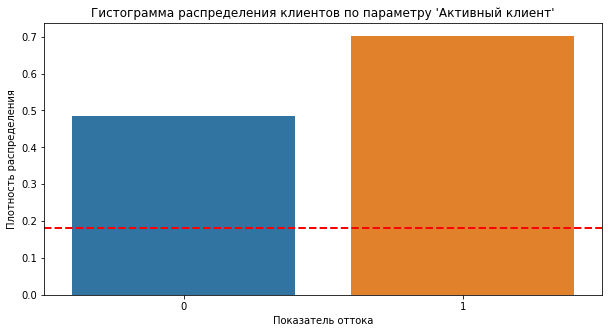

In [28]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Активный клиент'")
sns.barplot(data=df_rename, y= 'Активный клиент', x = 'Показатель оттока', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения'); 

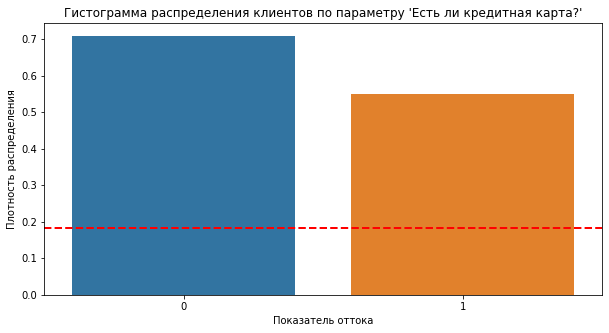

In [29]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Есть ли кредитная карта?'")
sns.barplot(data=df_rename, y= 'Есть ли кредитная карта?', x = 'Показатель оттока', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения'); 

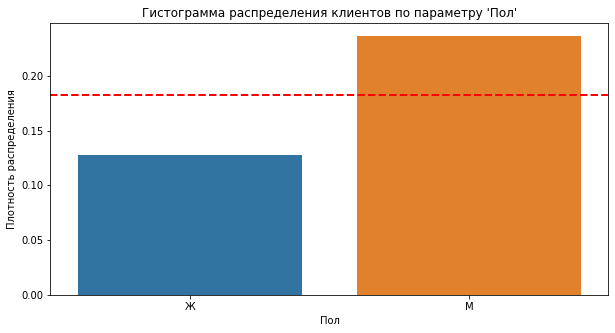

In [30]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Пол'")
sns.barplot(data=df_rename, x= 'Пол', y = 'Показатель оттока', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения'); 

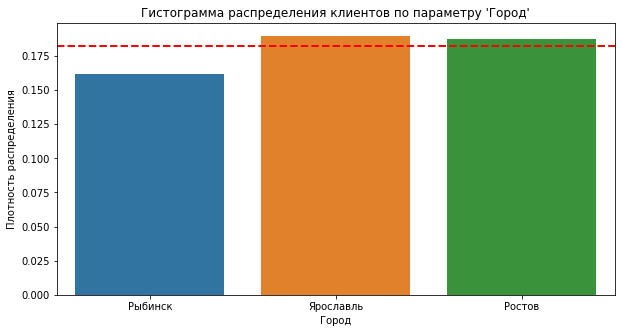

In [31]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Город'")
sns.barplot(data=df_rename, x= 'Город', y = 'Показатель оттока', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения'); 

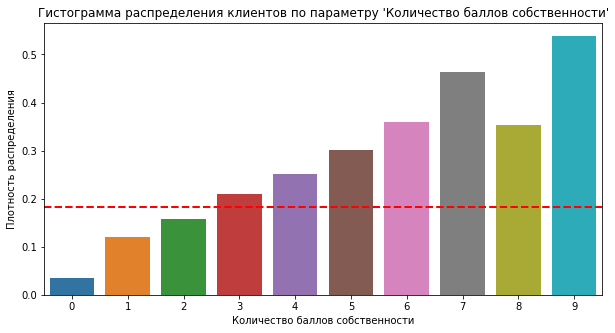

In [32]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Количество баллов собственности'")
sns.barplot(data=df_rename, y= 'Показатель оттока', x = 'Количество баллов собственности', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения');   

In [33]:
# При построении графика, параметр "Количество продуктов = 0" вел себя странно, проверим его
df_rename['Количество продуктов'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: Количество продуктов, dtype: int64

In [34]:
df_rename[df_rename['Количество продуктов'] == 0]

,user_id,Баллы кредитного скоринга,Город,Пол,Возраст,Количество баллов собственности,Баланс на счёте,Количество продуктов,Есть ли кредитная карта?,Активный клиент,Заработная плата клиента,Показатель оттока
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


In [35]:
#Всего одно значение, можно исключить для графика

df_rename = df_rename.drop(index = 8957, axis = 0)

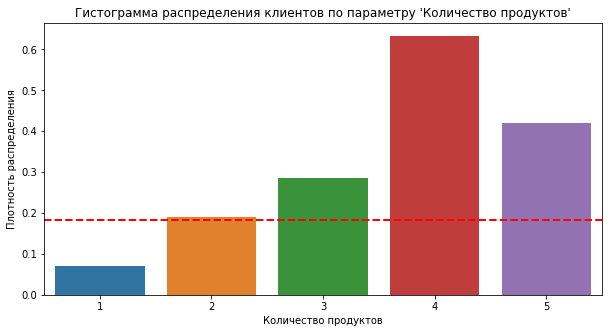

In [36]:
plt.figure(figsize=(10,5))
plt.title(f"Гистограмма распределения клиентов по параметру 'Количество продуктов'")
sns.barplot(data=df_rename, y= 'Показатель оттока', x = 'Количество продуктов', ci=None)
plt.axhline(y=np.nanmean(df_rename['Показатель оттока']), color='red', linestyle='--', linewidth= 2 , 
             label='Средний показатель оттока', zorder=1)
plt.ylabel('Плотность распределения');   

Выделим следующие интервалы значений характеристик, которые связаны с повышенным оттоком:

* Наличие продуктов - 3 и более

* Баланс на счете - от 750000 руб.

* Заработная плата в диапазоне 100-220 т.р.

* Количество баллов собственности - 3 и более

* Является активным клиентом

* Баллы кредитного скоринга - от 820 до 910

* Не имеется кредитной карты банка

* Мужчины чаще отказываются от услуг банка

* Возрастные группы 25-35 и 50-60 лет

* Клиент из города Ярославль


Общие выводы и реккомендации будут в конце главы.

## Сравнение портретов типичных клиентов, которые склонны и не склонны уходить из банка

In [37]:
portret_table = pd.DataFrame([
                    ['Средняя запрлата', df_churn_0['est_salary'].mean().round(decimals=2), df_churn['est_salary'].mean().round(decimals=2)],
                    ['Медианная запрлата', df_churn_0['est_salary'].median().round(decimals=2), df_churn['est_salary'].median().round(decimals=2)],
                    ['Средний кредитный рейтинг', df_churn_0['score'].mean().round(decimals=2), df_churn['score'].mean().round(decimals=2)],
                    ['Медианный кредитный рейтинг', df_churn_0['score'].median().round(decimals=2), df_churn['score'].median().round(decimals=2)],
                    ['Средний баланс счета', df_churn_0['balance'].mean().round(decimals=2), df_churn['balance'].mean().round(decimals=2)],
                    ['Медианный баланс счета', df_churn_0['balance'].median().round(decimals=2), df_churn['balance'].median().round(decimals=2)],
                    ['Средний возраст', df_churn_0['age'].mean().round(), df_churn['age'].mean().round()],
                    ['Медианное количество продуктов', df_churn_0['products'].median(), df_churn['products'].median()],
                    ['Медианное количество собственности', df_churn_0['equity'].median(), df_churn['equity'].median()],
                    ['Медианное количество собственности', df_churn_0['equity'].median(), df_churn['equity'].median()],
                    ['Мода по городу', df_churn_0['city'].mode()[0], df_churn['city'].mode()[0]],
                    ['Мода по полу', df_churn_0['gender'].mode()[0], df_churn['gender'].mode()[0]],
                    ['Есть ли кредитная карта?', df_churn_0['credit_card'].agg(pd.Series.mode)[0], df_churn['credit_card'].mode()[0]]
                             ])
portret_table.columns = ['Параметр', 'Неотток', 'Отток']

display(portret_table)

,Параметр,Неотток,Отток
0,Средняя запрлата,147783.2,148243.01
1,Медианная запрлата,118257.72,125390.62
2,Средний кредитный рейтинг,845.43,863.4
3,Медианный кредитный рейтинг,848.0,866.0
4,Средний баланс счета,733982.59,1133993.27
5,Медианный баланс счета,475382.44,782410.47
6,Средний возраст,43.0,41.0
7,Медианное количество продуктов,2.0,2.0
8,Медианное количество собственности,3.0,4.0
9,Медианное количество собственности,3.0,4.0


В результате анализа портретов типичных клиентов по признаку оттока мы видим, что ряд критериев довольно схожи, но самая главная черта клиентов, которые перестают пользоваться услугами банка - более высокий уровень достатка.


Соответственно, для удержания клиентов рекомендуем разработать продуктовые предложения в следующих направлениях:

* Бонусные программы кэшбэков/иных предложенний, для клиентов с высоким уровнем средств на счетах (подобные программы есть у банка "Открытие")

* Разработать линейку продуктов, ориентированных на объекты собственномти клиента (автомобили, недвижимость и т.д.), партнерские программы со страховыми компаниями (возможно, такими же региональниками как и сам банк).

* Пересмотреть условия по уже имеющимся продуктовым предложениям, сравнить с предложениями конкурентов.

# Шаг 3. Статистические гипотезы

## Формулировка гипотез

В рамках нашего исследования, проверим следующие наборы гипотез:

Н0: Различия дохода между теми клиентами, которые ушли и теми, которые остались отсутствуют.

Н1: Есть различие дохода между теми клиентами, которые ушли и теми, которые остались.





Н0: Различия баланса банковского счета между теми клиентами, которые ушли и теми, которые остались отсутствуют.

Н1: Есть различие баланса банковского счета между теми клиентами, которые ушли и теми, которые остались.

Н0 - Отток клиентов не связан с городом, в котором обслуживается клиент

Н1 - Отток клиентов связан с городом, в котором обслуживается клиент

## Обоснование инструментов и проверка

**Для начала определимся с инструметарием проверок.**

Для первых двух наборов будет применятся t-критерий Уэлча, т.к размеры выборок различаются. В данном случае применение t-теста обоснованно, т.к. данные совокупности независимы друг от друга,  размеры выборок составляют более тысячи значений в каждой, а значит выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности.

Так как у нас нет уверенности, что дисперсии выборок одинаковые, тест посчитает дисперсии выборок по отдельности при параметре `equal_var=False`.

Для третьего набора гипотез применим тест Пирсона по хи-квадрату, т.к. необходимо работать с категориальными переменными.

Приступим.

Н0: Различия дохода между теми клиентами, которые ушли и теми, которые остались отсутствуют.

Н1: Есть различие дохода между теми клиентами, которые ушли и теми, которые остались.

In [38]:
est_salary_0 = df[df['churn'] == 0]['est_salary']
est_salary_1 = df[df['churn'] == 1]['est_salary']


# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    est_salary_0, 
    est_salary_1,
    equal_var=False)

# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8887054822123845
Не получилось отвергнуть нулевую гипотезу


Н0: Различия баланса банковского счета между теми клиентами, которые ушли и теми, которые остались отсутствуют.

Н1: Есть различие баланса банковского счета между теми клиентами, которые ушли и теми, которые остались.

In [39]:
est_balance_0 = df[df['churn'] == 0]['balance']
est_balance_1 = df[df['churn'] == 1]['balance']

est_balance_0 = est_balance_0.dropna().astype('float')
est_balance_1 = est_balance_1.dropna().astype('float')

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    est_balance_0, 
    est_balance_1,
    equal_var=False)

# вывод значения p-value на экран 
print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.0439782929669127e-13
Отвергаем нулевую гипотезу


Проверим параметрические переменные, самое интересное.

Связан ли отток клиентов с городом, в котором обслуживается клиент?
Составим таблицу сопряженности.

In [40]:
cont_table = code_df.pivot_table(index='churn', values=['city_Ростов', 'city_Рыбинск', 'city_Ярославль'], aggfunc='sum')
cont_table

,city_Ростов,city_Рыбинск,city_Ярославль
churn,,,
0,1151.0,2258.0,4771.0
1,266.0,437.0,1117.0


Cформулируем гипотезы:

Н0 - Отток клиентов не связан с городом, в котором обслуживается клиент

Н1 - Отток клиентов связан с городом, в котором обслуживается клиент 

In [41]:
table = np.array([[1151, 2217, 4739], [266, 437, 1117]])
res = st.chi2_contingency(table)

# вывод значения p-value на экран 
print('p-значение:', res[1])
# условный оператор с выводом строки с ответом
if res[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
# Как мало строк кода, как много боли, что бы изучить

p-значение: 0.014170641384844147
Отвергаем нулевую гипотезу


Подведем итоги тестирования гипотез.

В конечном итоге, мы можем сделать вывод, что:

* Различия дохода между теми клиентами, которые ушли и теми, которые остались отсутствуют.

* Есть различие баланса банковского счета между теми клиентами, которые ушли и теми, которые остались.

* Отток клиентов связан с городом, в котором обслуживается клиент

Из новых инсайтов - все таки стоит обратить внимание на работу Ярославского подразделения банка.

# Шаг 4. Сегментация и приоретизация сегментов

Для начала работы сокращения оттока клиентов банка необходимо определить приоритетные сегменты, с которых стоит начать работу.

Выделим критерии, по которым будем формировать сегменты:

* Город обслуживания - Ярославль
* Мужской пол
* Кредитный рейтинг в диапазоне 850-910
* Возраст клиента в двух диапазонах 25-35 и 50-60
* Баланс счета более 750000
* Заработная плата в диапазоне 100-220 т.р.
* Отсутствие кредитной карты
* Является активным клиентом
* Количество баллов собственности более 2
* Количество продуктов банка более 2

In [42]:
# Начинаем ad-hoc магию, подготовим переменные
city = 'city == "Ярославль"'
gender = 'gender == "М"'
score = '850 <= score <= 910'
age1 = '50 <= age <= 60' 
age2 = '25 <= age <= 35'
balance = 'balance >= 750000'
salary = '100000 <= est_salary <= 220000'
credit_card = 'credit_card == 0'
activity = 'last_activity == 1'
equity = 'equity > 2'
products = 'products >= 2'

list = [city, gender, score, balance, salary, credit_card, activity, equity, products, age1]
list1 = [age2]
list2 = [city, gender, score, balance, salary, credit_card, activity, equity, products]

In [43]:
# Подготовим таблицу, в которую будут записываться сегменты
segments = pd.DataFrame({'segment':[], 'segment_amount':[], "churn_rate":[]
    })
display(segments)

,segment,segment_amount,churn_rate


In [44]:
# Вложенный цикл, который переберет сегменты
for i in list:
    for j in list:
        segments.loc[ len(segments.index )] = [f'{str(i)} и {str(j)}', 
              len(df.query(f'{i} and {j}')), 
              len(df.query(f'{i} and {j} and churn == 1 '))
              /len(df.query(f'{i} and {j}'))*100]

In [45]:
# Пробуем два возрастных сегмента, приходится разваодить их по разным листам, чтобы цикл не выпал в ошибку из-за деления на ноль
for i in list1:
    for j in list2:
        segments.loc[ len(segments.index )] = [f'{str(i)} и {str(j)}', 
              len(df.query(f'{i} and {j}')), 
              len(df.query(f'{i} and {j} and churn == 1'))
              /len(df.query(f'{i} and {j}'))*100] 

In [46]:
# Отфильтруем сегменты под необходимые условия размер > 500 и отток выше среднего по банку
top_segments = segments.query('segment_amount > 500 and churn_rate > @churn_rate').sort_values(by='segment_amount', ascending=False, ignore_index=True)
top_segments = top_segments.drop_duplicates(subset='segment_amount', keep='first', ignore_index=True)
top_segments = top_segments.drop(index = [0, 1, 3, 4, 6, 12, 17, 18, 45],axis = 0)

top_segments.columns = ['Сегмент', 'Численность сегмента', "Процент оттока"]
top_segments['КПД сегмента'] = (top_segments['Процент оттока'] * 0.01) * top_segments['Численность сегмента']
pd.set_option('display.max_rows', None)
display(top_segments.sort_values(by='КПД сегмента', ascending=False, ignore_index=True))

,Сегмент,Численность сегмента,Процент оттока,КПД сегмента
0,equity > 2 и equity > 2,5582.0,26.352562,1471.0
1,last_activity == 1 и products >= 2,3470.0,32.363112,1123.0
2,equity > 2 и last_activity == 1,2928.0,36.509563,1069.0
3,"gender == ""М"" и products >= 2",3198.0,31.644778,1012.0
4,"products >= 2 и city == ""Ярославль""",3856.0,25.596473,987.0
5,"equity > 2 и gender == ""М""",2728.0,35.447214,967.0
6,100000 <= est_salary <= 220000 и 100000 <= est...,4721.0,20.398221,963.0
7,balance >= 750000 и balance >= 750000,2704.0,34.800296,941.0
8,"equity > 2 и city == ""Ярославль""",3240.0,28.549383,925.0
9,balance >= 750000 и products >= 2,2376.0,37.163300,883.0


Так как в первых четырех позициях рисковые критерии пересекаются, попробуем посмотреть сводную группу по расширенным критериям, так сказать "Суперсегмент". Работа с этим сегментом позволит сэкономить ресурсы, т.к. имеет несколько пересекающихся признаков.

In [47]:
print('Размер суперсегмента:', len(df.query('equity >= 2 and last_activity == 1 and city == "Ярославль" and gender == "М"')))
print('Процент оттока:', len(df.query('equity >= 2 and last_activity == 1 and city == "Ярославль" and churn == 1 and gender == "М"')) / len(df.query('equity >= 2 and last_activity == 1 and city == "Ярославль" and gender == "М"'))*100)


Размер суперсегмента: 914
Процент оттока: 45.51422319474836


In [48]:
print('Размер суперсегмента:', len(df.query('last_activity == 1 and credit_card == 0  and  850 <= score <= 910')))
print('Процент оттока:', len(df.query('last_activity == 1 and credit_card == 0  and  850 <= score <= 910 and churn == 1')) / len(df.query('last_activity == 1 and credit_card == 0  and  850 <= score <= 910'))*100)


Размер суперсегмента: 687
Процент оттока: 51.96506550218341


In [49]:
print('Размер суперсегмента:', len(df.query('850 <= score <= 910 and balance >= 750000  and 100000 <= est_salary <= 220000')))
print('Процент оттока:', len(df.query('850 <= score <= 910 and 100000 <= est_salary <= 220000  and balance >= 750000 and churn == 1')) / len(df.query('850 <= score <= 910 and 100000 <= est_salary <= 220000  and balance >= 750000 '))*100)


Размер суперсегмента: 639
Процент оттока: 48.6697965571205


Комбинации признаков объединяются по двум основным признакам: 

1) Допустить как можно меньшее пересечение признаков в сегментах

2) Сформировать целостный портрет клиента, а не только обстрактный набор формальных признаков.

Таким образом, можно обозначить следующие приоритетные сегменты для работы:

1) Активные клинеты-мужчины, имеющие баллы собственности больше 2 из г. Ярославля - 914 человек, процент оттока - 51.9%

Рекомендация: Разработать/предложить имеющиеся продукты, связанные недвижимостью, автомобилями, программы страхования, кэшбек программы связанные авто (заправки, сервисные центры и запчасти, мойки, детейлинги и т.д.), недвижимостью (магазины строит. товаров, мебель и т.д.)

2) Активные  клиенты имеющие кредитный рейтинг в интервале 850-910, не имеющие кредитной карты банка - 687 человек, процент оттока - 51,9%
Рекомендация: предложить кредитные продукты на крупные суммы, целевые кредиты на приоборетение авто, ипотеки, кредитные карты с большими кредитными лимитами.

3) Клиенты имеющие кредитный рейтинг в интервале 850-910, баланс на счете более 750 т.р и зарплатой в интервале 100-220 т.р. - 639 человек, процент оттока 48,6%

Рекомендация: Предложить инвестиционные продукты, депозитные счета, с повышенными процентными ставками, что бы привлечь денежные средства клиента на длительный срок.

Сегменты приоретизированы по условному "КПД сегмента", отталкивающийся от количества отточных клиентов внутри сформированного сегмента.

Оптимальной стратегией в дальнейшем сформировать единую базу клиентов в зоне риска на основании данной сегментации и исключая пересекающихся клиентов в сегментах.

# Шаг 5. Общие выводы / Презентация по работе/ Дашборд

## Итоги работы

В конце исследования подведем итоги и соберем ключевые выводы.

**В результате исследовательского анализа данных выделены следующие факторы, влияющие на отточность клиентов и установлены их интервалы:**

* Наличие продуктов - 3 и более

* Баланс на счете - от 750 000 руб.

* Зарплата в интервале 100-220 т.р.

* Количество баллов собственности - 3 и более

* Является активным клиентом

* Баллы кредитного скоринга - от 820 до 910

* Не имеется кредитной карты банка

* Мужчины чаще отказываются от услуг банка

* Возрастные группы 25-35 и 50-60 лет

* Клиент из города Ярославль



**В результате анализа портретов типичных клиентов по признаку оттока** мы видим, что ряд критериев довольно схожи, но самая главная черта клиентов, которые перестают пользоваться услугами банка - более высокий уровень достатка.


Соответственно, для удержания клиентов рекомендуем разработать продуктовые предложения в следующих направлениях:

* Бонусные программы кешбеков/иных предложенний, для клиентов с высоким уровнем средств на счетах (подобные программы есть у банка "Открытие")

* Разработать линейку продуктов, ориентированных на объекты собственномти клиента (автомобили, недвижимость и т.д.), партнерские программы со страховыми компаниями (возможно, такими же региональниками как и сам банк).

* Пересмотреть условия по уже имеющимся продуктовым предложениям, сравнить с предложениями конкурентов.

**В результате корреляционного анализа установлена следующая взаимосвязь между признаком отточности клиентов прочими факторами:**

1) Наличие продуктов, которыми пользуется клиент (Products, коэффициент 0,3, phik 0.4)

2) Количество баллов собственности (Equity, коэффициент 0,27)

3) Статус активного клиента (Last_activity, коэффициент 0,17)

4) Баллы кредитного скоринга, (Score, коэффициент 0,11)

5) Наличие кредитной карты (Credit_сard, коэффициент -0,13)

**Факторы по Phik-корреляции, которые были включены дополнительно:**

1) Пол (0,22)

2) Возраст (0,2)

В целом, имеющуюся корреляцию можно оценить как слабую и очень слабую, в обеих методиках расчета по параметру оттока мы не получаем коэфициент выше 0,4. Однако, несмотря на расхождения коэфициентов между методиками, можно отметить что в целом, они обращают внимание на одни и те же факторы.


**В результате проверки статистических гипотез получены следующие выводы:**

* Различия дохода между теми клиентами, которые ушли и теми, которые остались отсутствуют.

* Есть различие баланса банковского счета между теми клиентами, которые ушли и теми, которые остались.

* Отток клиентов связан с городом, в котором обслуживается клиент

На основе полученных результатов рекоммендуем исследовать работу и показатели Ярославского подразделения банка.

**В результате выявления сегментов для оперативной работы по снижению уровня оттока, реккомендуем следующие приоритетные сегменты:**

1) Активные клинеты-мужчины, имеющие баллы собственности больше 2 из г. Ярославля - 914 человек, процент оттока - 45.5%

Рекомендация: Разработать/предложить имеющиеся продукты, связанные недвижимостью, автомобилями, программы страхования, кэшбек программы связанные авто (заправки, сервисные центры и запчасти, мойки, детейлинги и т.д.), недвижимостью (магазины строит. товаров, мебель и т.д.)

2) Активные  клиенты имеющие кредитный рейтинг в интервале 850-910, не имеющие кредитной карты банка - 687 человек, процент оттока - 51,9%
Рекомендация: предложить кредитные продукты на крупные суммы, целевые кредиты на приоборетение авто, ипотеки, кредитные карты с большими кредитными лимитами.

3) Клиенты имеющие кредитный рейтинг в интервале 850-910, баланс на счете более 750 т.р и зарплатой в интервале 100-220 т.р. - 639 человек, процент оттока 48,6%

Рекомендация: Предложить инвестиционные продукты, депозитные счета, с повышенными процентными ставками, что бы привлечь денежные средства клиента на длительный срок.

Сегменты приоретизированы по условному "КПД сегмента", отталкивающийся от количества отточных клиентов внутри сформированного сегмента.

Оптимальной стратегией в дальнейшем сформировать единую базу клиентов в зоне риска на основании данной сегментации и исключая пересекающихся клиентов в сегментах.

## Презентация

**Презентация:** <https://disk.yandex.ru/i/IdwQv5ToEE0Jzg>

## Дашборд

Дашборд из набора №2 в виде диаграммы, отображающую распределение заработной платы.

Помимо фильтров из тех.задания добавил фильтр на размер заработной платы для удобства использования дашборда.

[Ссылка на дашборд](https://public.tableau.com/views/_16883693280090/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)